---
title: Optimal Transport for Generative Models
author: Mark Fuge
date: 'October 12 2025'
format:
    html:
        code-fold: true
        code-summary: "Show Code"
---

In the previous notebooks, we explored how Generative Adversarial Networks (GANs) use a minimax game between a Generator and Discriminator to learn data distributions. However, we saw that this adversarial training can lead to instability, mode collapse, and other training difficulties. In this notebook, we'll explore an alternative approach based on **Optimal Transport (OT)**, which provides a more direct way to measure the distance between probability distributions.

The key insight is this: instead of training a discriminator to distinguish real from fake samples, we can directly minimize the distance between the generated distribution and the real data distribution using optimal transport metrics. This often leads to more stable training and better coverage of the data distribution.

In [16]:
# Setup and Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim


# Optional interactive widgets
try:
    from ipywidgets import interact, FloatSlider, IntSlider
    widgets_available = True
except Exception:
    interact = None
    FloatSlider = IntSlider = None
    widgets_available = False

# Import geomloss for optimal transport
try:
    from geomloss import SamplesLoss
    geomloss_available = True
except ImportError:
    print("Warning: geomloss not available. Install with: pip install geomloss")
    geomloss_available = False

# Import shared utilities from the local module
from gen_models_utilities import (
    device, create_ring_gaussians,
    make_loader, compute_diversity_metric, plot_model_diagnostics, plot_latent_interpolation
)

plt.style.use('seaborn-v0_8-muted')
sns.set_context('talk')

#print(f"Using device: {device}")

## What is Optimal Transport?

Let's go back to our earlier analogy where we were imagining probability distributions as two piles of sand, and our goal is to transform one pile into the other. Optimal transport addresses the question: **What is the most efficient way to move the sand from one configuration to another?**

More formally, given two probability distributions $z$ and $x$, optimal transport finds a transport plan $\pi$ that moves mass from $z$ to $x$ while minimizing the total *transport cost*. There are many possible definitions of cost here, and it is common to think of a distance as a form of cost, with the **Wasserstein distance** (also called the Earth Mover's Distance) as a common one with the technical form:
$$
W_p(z, x) = \left( \inf_{\pi \in \Pi(z, x)} \int \|x - y\|^p \, d\pi(x, y) \right)^{1/p}
$$

where $\Pi(z, x)$ is the set of all joint distributions with marginals $z$ and $x$.

OK, so far so good in principle -- I just need to find the transport plan that minimizes some p-norm over all joint distributions of $z$ and $x$. However, in practice, this is not so straightforward, since finding a minimum over all possible joint distributions of $z$ and $x$ is not so computationally tractable.[^1]

[^1]: At a high level, this is due to a combinatoric assignment problem in something called the coupling matrix, where you are trying to match generated and real datapoints to one another and optimize for the lowest distance. Because this assignment matrix is ultimately a binary matrix, this makes it not easily differentiable.

Instead, of computing the Wasserstein distance directly, we will compute an approximate version of it that regularizes the transport plan, and is called computing the **Sinkhorn Divergence**. Going over the specific implementation details of the Sinkhorn Divergence (which rely on Sinkhorn Iteration and knowledge of doubly stochastic matrices) are beyond the scope of what I want to cover in these notebooks, but interested students can check out [Computational Optimal Transport](https://arxiv.org/abs/1803.00567) by Gabriel Peyré and Marco Cuturi for further details. 

The important thing to know in the context of a course at this level is that the Sinkhorn Divergence can only *approximate* the true Wasserstein distance, and that it does so via what is often called a "blur" parameter. This parameter is essentially a smoothing term that determines how much we penalize the complexity of the transport map. Some small amount of blur will help us compute gradients and use the Sinkhorn Divergence in ML model training, but too much of this will prevent a model from capturing fine details in the data distribution. You will see an interactive example of this next before we move on to using OT for GAN training. 


### Simple Optimal Transport Example 

Let's start with a familiar and concrete example that we have been using in the prior GAN notebooks. We'll take a simple 2D Gaussian and compute its optimal transport to our ring of Gaussians dataset. We'll visualize the transport map by computing the transport vectors (i.e., in what direction we move the probability mass) and also demonstrate how moving in those directions shifts our 2D Gaussian towards the ring.

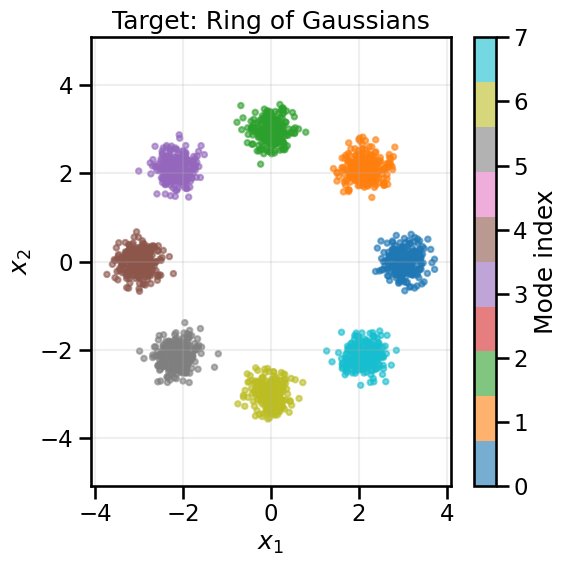

In [15]:
# Load the ring dataset
X_ring, y_ring = create_ring_gaussians(n_samples=2000)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sc = ax.scatter(X_ring[:, 0], X_ring[:, 1], c=y_ring, cmap='tab10', s=15, alpha=0.6)
plt.colorbar(sc, label='Mode index')
ax.set_title('Target: Ring of Gaussians')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.axis('equal')
ax.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

Now what we will do below is place a simple 2D Gaussian distribution centered at the origin, and then compute the Sinkhorn Divergence (loss) between each point in the real dataset and each point in the simple 2D Gaussian. Using Automatic Differentiation, we can then compute how to move each point in the generated distribution to minimize this loss. We will plot a sample of these gradient vectors so that you can see what the transport map looks like and also take a (very large) step in that direction for each point, so you can see the visual effect of the transport.

In this case, we are only taking a single, giant step along the transport map for pedagogical purposes, but in reality (and as we will do later), you would move slowly along the transport map over many iterations to gradually morph the generated distribution into the real data distribution.

In [17]:
#| code-fold: false
# Create a simple 2D Gaussian source distribution
n_source = 2000
source_samples = np.random.randn(n_source, 2).astype(np.float32) * 0.5

# Convert to torch tensors
source_torch = torch.from_numpy(source_samples).to(device)
target_torch = torch.from_numpy(X_ring).to(device)

# Compute optimal transport using Sinkhorn algorithm
# The blur parameter controls entropic regularization (larger = more regularization)
sinkhorn_loss = SamplesLoss("sinkhorn", p=2, blur=0.05, scaling=0.9)
sinkhorn_loss = SamplesLoss("sinkhorn", p=2, blur=0.01, scaling=0.9)

# Compute transport plan by taking gradient
source_torch.requires_grad_(True)
loss = sinkhorn_loss(source_torch, target_torch)
loss.backward()

In [18]:
#| code-fold: false
# This is effectively a giant step size so the we can visualize the gradients
# and see a meaningful change in the distribution.
# In reality, we would take much smaller steps than this and do it over iterations
magnitude_scaling = 2000

# The gradient points in the direction of optimal transport
transport_direction = source_torch.grad.detach().cpu().numpy()
transported_points = source_samples + transport_direction*magnitude_scaling

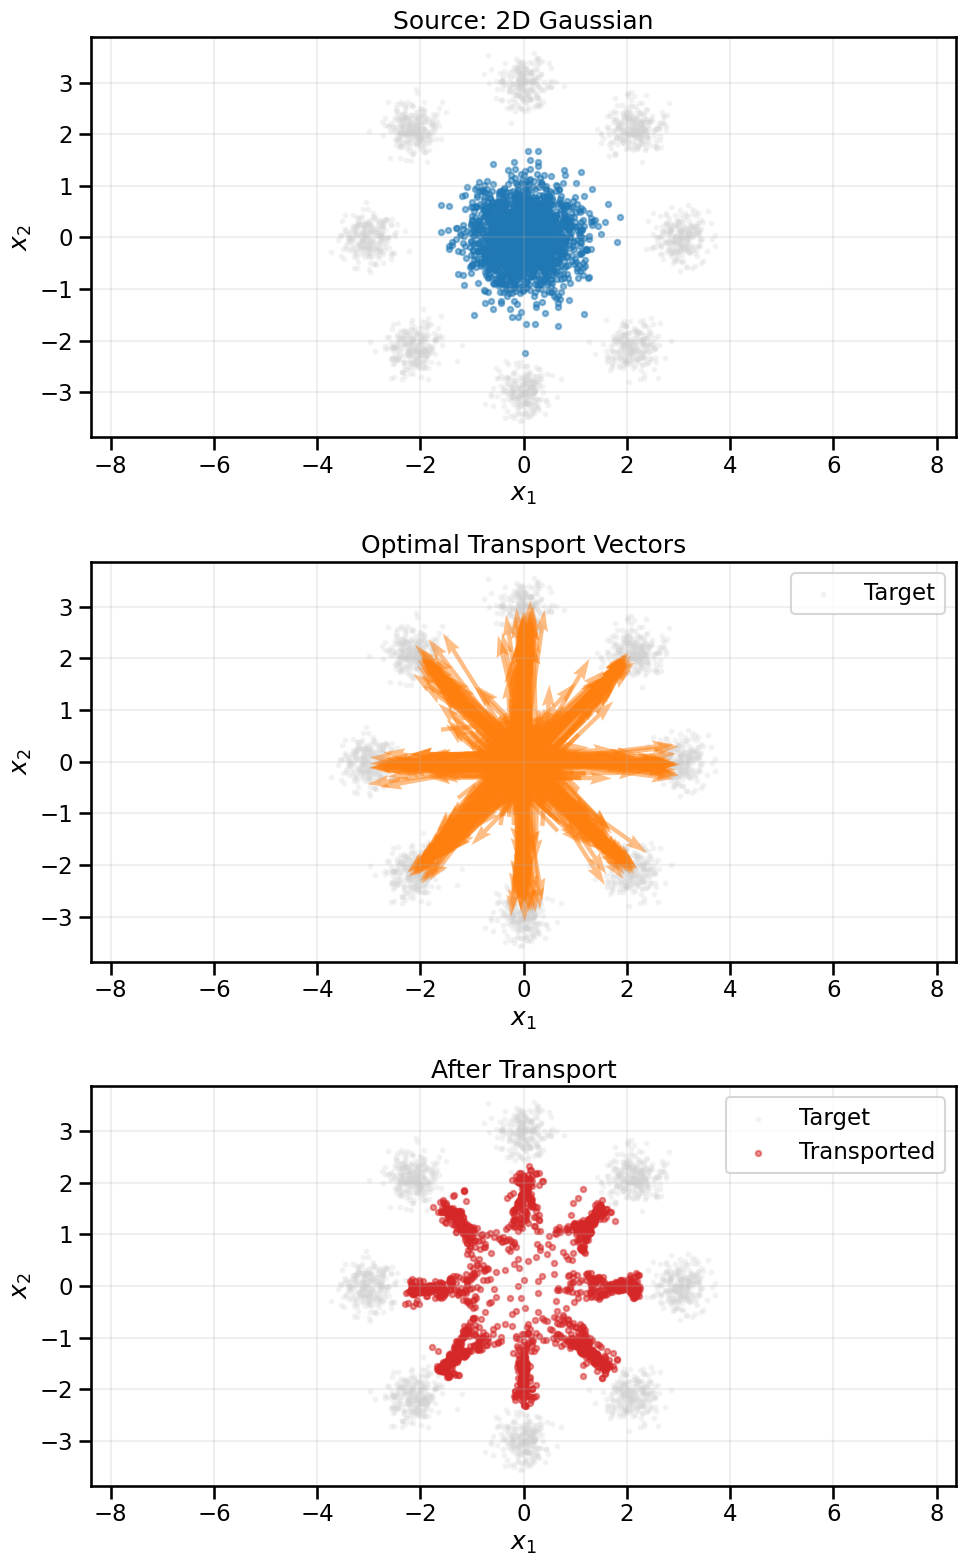

Sinkhorn divergence: 2.8399


In [21]:
# Visualize the transport
fig, axes = plt.subplots(3, 1, figsize=(10,16))

# Source distribution
axes[0].scatter(source_samples[:, 0], source_samples[:, 1], 
                s=15, alpha=0.5, c='tab:blue')
axes[0].scatter(X_ring[:, 0], X_ring[:, 1], 
                s=8, alpha=0.2, c='lightgray', label='Target')
axes[0].set_title('Source: 2D Gaussian')
axes[0].set_xlabel('$x_1$')
axes[0].set_ylabel('$x_2$')
axes[0].axis('equal')
axes[0].grid(True, alpha=0.2)

# Transport vectors
# Sample a subset for visualization clarity
idx_subset = np.random.choice(n_source, size=500, replace=False)
axes[1].scatter(X_ring[:, 0], X_ring[:, 1], 
                s=8, alpha=0.2, c='lightgray', label='Target')
axes[1].quiver(source_samples[idx_subset, 0], source_samples[idx_subset, 1],
                magnitude_scaling/1.5*transport_direction[idx_subset, 0], 
                magnitude_scaling/1.5*transport_direction[idx_subset, 1],
                angles='xy', scale_units='xy', scale=0.5, width=0.005, 
                color='tab:orange', alpha=0.5)
axes[1].set_title('Optimal Transport Vectors')
axes[1].set_xlabel('$x_1$')
axes[1].set_ylabel('$x_2$')
axes[1].axis('equal')
axes[1].grid(True, alpha=0.2)
axes[1].legend()

# Transported distribution
axes[2].scatter(X_ring[:, 0], X_ring[:, 1], 
                s=8, alpha=0.2, c='lightgray', label='Target')
axes[2].scatter(transported_points[:, 0], transported_points[:, 1], 
                s=15, alpha=0.5, c='tab:red', label='Transported')
axes[2].set_title('After Transport')
axes[2].set_xlabel('$x_1$')
axes[2].set_ylabel('$x_2$')
axes[2].axis('equal')
axes[2].grid(True, alpha=0.2)
axes[2].legend()

plt.tight_layout()
plt.show()

print(f"Sinkhorn divergence: {loss.item():.4f}")

In the visualization above, you can see how optimal transport naturally moves mass from the source Gaussian to the target ring distribution. The transport vectors (middle plot) show the direction and magnitude of how each point should move to minimize the total transport cost.


::: {.callout-tip appearance="default"}
### Experiment: Effect of Sinkhorn Divergence Parameters
The Sinkhorn divergence has several key parameters that affect the transport:

1. **`blur` ($\epsilon$)**: Controls the amount of entropic regularization. Larger values make the transport "smoother" but less accurate.
2. **`p`**: The p-norm used for measuring distances. This is typically `p=1` for Manhattan distance (sum of absolute differences) or `p=2` for Euclidean distance (standard L2 norm)).

Use the slider below to gain intuition about changing the effects of these three parameters:
- What effect does moving from a small blur to a large blur have?
- How does the transport pattern differ between p=1 and p=2?


:::



In [22]:
if geomloss_available and widgets_available:
    def explore_pnorm(p: int = 2, blur: float = 0.05):
        # Create source distribution
        source_samples = np.random.randn(1000, 2).astype(np.float32) * 0.5
        source_torch = torch.from_numpy(source_samples).to(device)
        target_torch = torch.from_numpy(X_ring[:1000]).to(device)
        
        # Compute transport
        sinkhorn_loss = SamplesLoss("sinkhorn", p=p, blur=blur, scaling=0.9)
        source_torch.requires_grad_(True)
        loss = sinkhorn_loss(source_torch, target_torch)
        loss.backward()
        
        magnitude_scaling = 1500
        
        transport_direction = source_torch.grad.detach().cpu().numpy()
        transported_points = source_samples + transport_direction * magnitude_scaling
        
        # Visualize
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        # Transport vectors
        idx_subset = np.random.choice(1000, size=150, replace=False)
        axes[0].scatter(X_ring[:, 0], X_ring[:, 1], 
                       s=8, alpha=0.15, c='lightgray', label='Target')
        axes[0].quiver(source_samples[idx_subset, 0], source_samples[idx_subset, 1],
                      magnitude_scaling/1.5*transport_direction[idx_subset, 0], 
                      magnitude_scaling/1.5*transport_direction[idx_subset, 1],
                      angles='xy', scale_units='xy', scale=1, width=0.003, 
                      color='tab:orange', alpha=0.7)
        axes[0].set_title(f'Transport Vectors (p={p}, blur={blur:.3f})')
        axes[0].set_xlabel('$x_1$')
        axes[0].set_ylabel('$x_2$')
        axes[0].axis('equal')
        axes[0].grid(True, alpha=0.2)
        axes[0].legend()
        
        # Result
        axes[1].scatter(X_ring[:, 0], X_ring[:, 1], 
                       s=8, alpha=0.2, c='lightgray', label='Target')
        axes[1].scatter(transported_points[:, 0], transported_points[:, 1], 
                       s=15, alpha=0.5, c='tab:red', label='Transported')
        axes[1].set_title(f'After Transport (loss={loss.item():.4f})')
        axes[1].set_xlabel('$x_1$')
        axes[1].set_ylabel('$x_2$')
        axes[1].axis('equal')
        axes[1].grid(True, alpha=0.2)
        axes[1].legend()
        
        plt.tight_layout()
        plt.show()
    
    interact(explore_pnorm, 
             p=IntSlider(min=1, max=2, step=1, value=2, description='p-norm'),
             blur=FloatSlider(min=0.01, max=0.7, step=0.01, value=0.05, description='Blur (ε)'))
elif not geomloss_available:
    print("GeomLoss not available. Please install it to run this experiment.")
else:
    print("ipywidgets not available. Please install it for interactive controls.")

interactive(children=(IntSlider(value=2, description='p-norm', max=2, min=1), FloatSlider(value=0.05, descript…

## Building an Entropic OT GAN

Now that we are beginning to understand optimal transport and how it might be useful, let's try to use it to train a generative model. Instead of using a discriminator (as in standard GANs), we'll directly minimize the Sinkhorn divergence between generated samples and real data. We can do this because the Sinkhorn divergence is now substituting for the original role of the Discriminator (i.e., to move the generator closer to real-world data), and so the Discriminator is no longer necessary.[^2]

[^2]: One could argue that we are no longer really doing a "GAN" here because we do not have an "Adversary" now that the Discriminator is gone, so it is perhaps misleading to call it this, but since earlier papers refer to this style of Generative Model as an Entropic GAN, I will be consistent with them, even if it isn't the best name in my view.

This approach has several advantages:

1. **No discriminator needed**: We only need the network for the Generator now, which is simpler and we fewer total parameters to train. We don't need to worry about two learning rates or different capacities in each network, like we saw in the GAN Pitfalls notebook.
2. **More stable to train**: Since we no longer have a minimax game to balance, we do not have to contend with oscillatory behavior of the optimizer and potentially getting trapped in a loop. This can also equate to faster training times as a result, if the learning rate is suitably tuned.
3. **Better coverage**: OT naturally encourages covering all modes of the data distribution, rather than hoping that a Discriminator pushes the Generator to cover all modes.
4. **Meaningful gradients**: Because OT computes a pairwise distance among all data points, so long as the gradient of our distance/cost measure remains finite and non-zero at far away distances, we can still perform useful gradient descent steps in the generative model. This is not the case for some other cost functions (such as the KL Divergence) where gradients might vanish if the two distributions are not close enough.

In [23]:
#| code-fold: false
class GeneratorMLP(nn.Module):
    """Simple MLP generator for 2D data."""
    def __init__(self, noise_dim: int = 2, hidden_dim: int = 256, out_dim: int = 2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(noise_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )
    
    def forward(self, z: torch.Tensor) -> torch.Tensor:
        return self.net(z)

In [24]:
#| code-fold: false
from dataclasses import dataclass
from typing import List

@dataclass
class SinkhornHistory:
    """Training history for Sinkhorn-based generator."""
    loss: List[float]
    diversity: List[float]

def train_sinkhorn_generator(
    data: np.ndarray,
    noise_dim: int = 2,
    batch_size: int = 256,
    epochs: int = 200,
    lr: float = 1e-3,
    hidden_dim: int = 256,
    blur: float = 0.05,
    p: int = 2,
    print_every: int = 50
) -> tuple:
    """
    Train a generator using Sinkhorn divergence.
    
    Args:
        data: Real data samples (numpy array)
        noise_dim: Dimension of latent noise
        batch_size: Batch size for training
        epochs: Number of training epochs
        lr: Learning rate
        hidden_dim: Hidden dimension for generator
        blur: Entropic regularization parameter
        p: p-norm for distance metric
        print_every: Print progress every N epochs
    
    Returns:
        Tuple of (trained generator, training history)
    """
    if not geomloss_available:
        raise ImportError("GeomLoss is required for Sinkhorn training. Install with: pip install geomloss")
    
    # Setup data loader
    loader = make_loader(data, batch_size)
    
    # Initialize generator and optimizer
    G = GeneratorMLP(noise_dim=noise_dim, hidden_dim=hidden_dim, out_dim=2).to(device)
    optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
    
    # Setup Sinkhorn loss
    sinkhorn_loss = SamplesLoss("sinkhorn", p=p, blur=blur, scaling=0.9, debias=True)
    
    # Training history
    history = SinkhornHistory(loss=[], diversity=[])
    
    print(f"Training Sinkhorn OT Generator for {epochs} epochs...")
    print(f"Parameters: blur={blur}, p={p}, lr={lr}, hidden_dim={hidden_dim}")
    
    for epoch in range(epochs):
        epoch_losses = []
        
        for (real_batch,) in loader:
            real_batch = real_batch.to(device)
            
            # Generate fake samples
            z = torch.randn(batch_size, noise_dim, device=device)
            fake_batch = G(z)
            
            # Compute Sinkhorn divergence
            loss = sinkhorn_loss(fake_batch, real_batch)
            
            # Update generator
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_losses.append(float(loss.detach().cpu().item()))
        
        # Record metrics
        mean_loss = float(np.mean(epoch_losses))
        
        # Compute diversity
        with torch.no_grad():
            z_eval = torch.randn(2048, noise_dim, device=device)
            samples = G(z_eval)
            diversity = compute_diversity_metric(samples)
        
        history.loss.append(mean_loss)
        history.diversity.append(diversity)
        
        if (epoch + 1) % print_every == 0 or epoch == 0:
            print(f"Epoch {epoch+1:03d}/{epochs} | Loss: {mean_loss:.4f} | Diversity: {diversity:.4f}")
    return G, history

Let's train the OT generator on our ring dataset:

Training Sinkhorn OT Generator for 200 epochs...
Parameters: blur=0.02, p=2, lr=0.001, hidden_dim=256
Epoch 001/200 | Loss: 3.0143 | Diversity: 1.4045
Epoch 050/200 | Loss: 0.2361 | Diversity: 4.2275
Epoch 100/200 | Loss: 0.1821 | Diversity: 4.4085
Epoch 150/200 | Loss: 0.1931 | Diversity: 4.4977
Epoch 200/200 | Loss: 0.2302 | Diversity: 4.5730


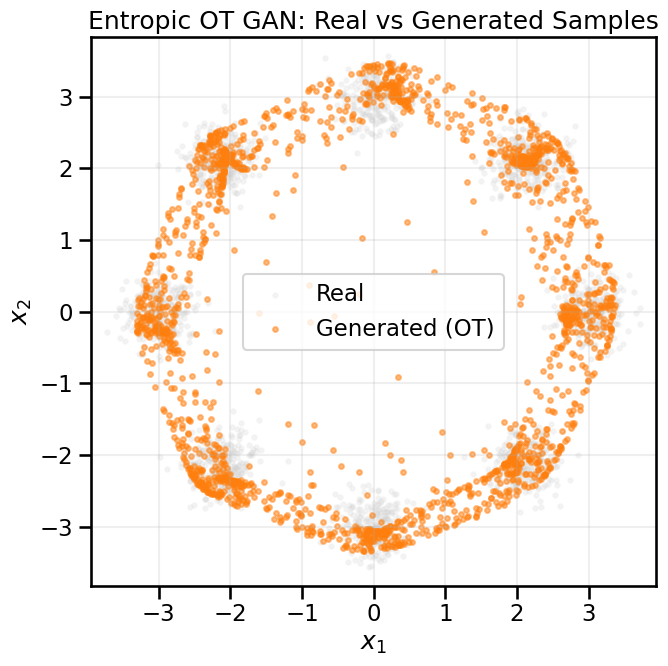

In [25]:
if geomloss_available:
    # Train the generator
    G_ot, H_ot = train_sinkhorn_generator(
        X_ring,
        epochs=200,
        batch_size=256,
        noise_dim=2,
        hidden_dim=256,
        blur=0.02,
        p=2,
        lr=1e-3,
        print_every=50
    )
    
    # Generate and visualize samples
    with torch.no_grad():
        z_test = torch.randn(2000, 2, device=device)
        generated_samples = G_ot(z_test).cpu().numpy()
    
    fig, ax = plt.subplots(1, 1, figsize=(7, 7))
    ax.scatter(X_ring[:, 0], X_ring[:, 1], 
              s=10, alpha=0.2, c='lightgray', label='Real')
    ax.scatter(generated_samples[:, 0], generated_samples[:, 1], 
              s=12, alpha=0.5, c='tab:orange', label='Generated (OT)')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_title('Entropic OT GAN: Real vs Generated Samples')
    ax.legend()
    ax.axis('equal')
    ax.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()
else:
    print("GeomLoss not available. Please install it to train the OT generator.")

Let's use our standard diagnostic plots from the GAN notebooks to evaluate the OT generator's performance:

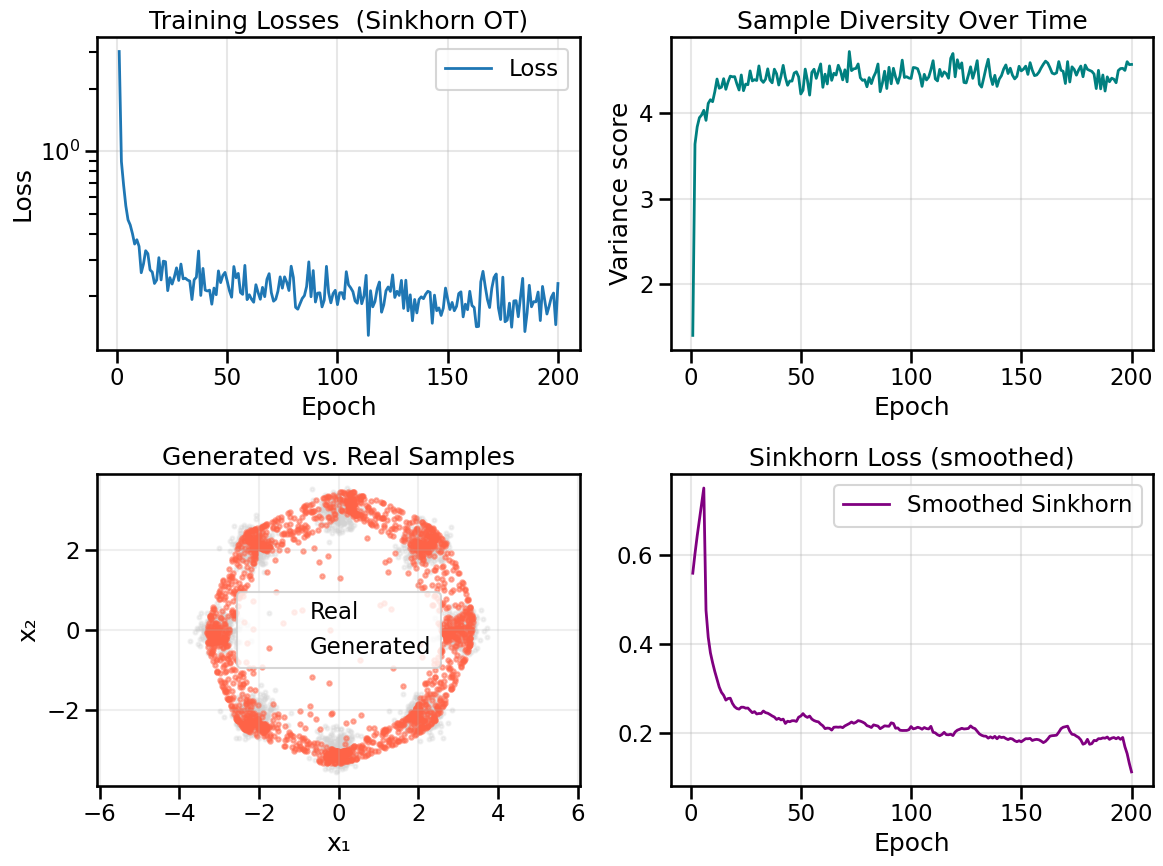

In [27]:
plot_model_diagnostics(
    H_ot, 
    X_ring, 
    G_ot, 
    noise_dim=2, 
    title_suffix=' (Sinkhorn OT)'
)

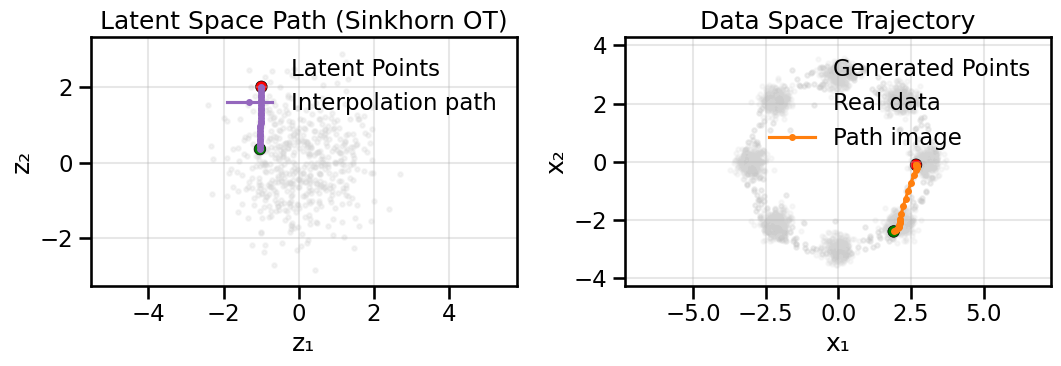

In [28]:
plot_latent_interpolation(
    G_ot, 
    noise_dim=2, 
    title_suffix=' (Sinkhorn OT)',
    real_samples=X_ring
)

## Summary and Next Steps

In this notebook, we explored how Optimal Transport provides an alternative to adversarial training for generative models:

1. **Optimal Transport Intuition**: OT finds the most efficient way to transform one distribution into another, providing meaningful gradients even when distributions don't overlap.

2. **Sinkhorn Divergence**: By adding entropic regularization, we make OT computationally tractable while preserving most benefits. The `blur` parameter controls the trade-off between precision and smoothness.

3. **Entropic OT GANs**: We can train generative models by directly minimizing Sinkhorn divergence, eliminating the need for a discriminator and the associated minimax game.

4. **Advantages over Traditional GANs**:
   - Simpler architecture (no discriminator)
   - More stable training (no adversarial dynamics)
   - Better mode coverage (OT naturally spreads mass)
   - Meaningful loss values (directly related to distribution distance)

5. **Trade-offs**: OT-based training requires careful tuning of the `blur` parameter and can be computationally expensive for very large datasets. In particular, OT-based distances are very good when the source and target distributions are already well aligned, but less so when the transport distance is high (since then the optimal map computed by Sinkhorn Iteration may not be as discriminative). As a consequence, many real-world applications of OT in a generative model context use OT as a fine-tuning step after doing an alignment or registration step (e.g., when matching a mesh of an organ to data from a CT scan).

So, at this point we have addressed one of the key weaknesses of GANs -- the instability of adversarial training -- by removing the discriminator entirely and replacing it with a direct measure of distribution distance. However, there is still one big missing piece to be desired by Entropic GAN-style models. While we have a better forward map now of $f(z) \rightarrow x$ via the generator, we still do not have an inverse map $f^{-1}(x) \rightarrow z$ that would allow us to encode real data points back into the latent space. This is something that Variational Autoencoders (VAEs) and Normalizing Flows provide, and is where we turn our attention next. We will see that the general concept of OT will raise its head again after Normalizing Flows in the context of something called "Flow Matching", and we will return to this in a few notebooks.